<a href="https://colab.research.google.com/github/adenurchalisa/DeepLearning_finalproject/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ultralytics
!pip install -q optuna
!pip install -q tensorboard

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import cv2
import random
import shutil
from tqdm.auto import tqdm
from ultralytics import YOLO
from google.colab import drive

In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Path ke dataset
dataset_dir = "/content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/dataset/dataset_augmented"
model_dir = "/content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/models"
processed_data_dir = "/content/classify_data_v3"  # Nama baru untuk menghindari konflik

In [ ]:
# Kategori dan parameter global
CATEGORIES = ["sangat_kotor", "sedang", "sangat_bersih"]
IMG_SIZE = 224
BATCH_SIZE = 16  # Lebih kecil untuk menghindari masalah memori
EPOCHS = 20
SEED = 42

# Pastikan direktori model ada
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set random seed untuk reproducibility
def seed_everything(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(SEED)

In [ ]:
# Persiapan dataset dengan struktur folder yang benar untuk klasifikasi
def prepare_classification_dataset(dataset_dir, output_dir):
    """
    Menyiapkan dataset dalam format klasifikasi standar:
    /train/class_name/image.jpg
    /val/class_name/image.jpg
    """
    print(f"Preparing dataset from {dataset_dir} to {output_dir}")

    # Hapus output_dir jika sudah ada
    if os.path.exists(output_dir):
        print(f"Removing existing {output_dir}")
        shutil.rmtree(output_dir)

    # Buat struktur folder
    os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val"), exist_ok=True)

    # Dataset split info
    train_data = []
    val_data = []

    for i, category in enumerate(CATEGORIES):
        category_dir = os.path.join(dataset_dir, category)
        if not os.path.exists(category_dir):
            print(f"Warning: Category directory {category_dir} does not exist")
            continue

        # Buat folder kategori di train dan val
        os.makedirs(os.path.join(output_dir, "train", category), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "val", category), exist_ok=True)

        images = [f for f in os.listdir(category_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Shuffle images
        random.shuffle(images)

        # Split into train/val (80/20)
        split_idx = int(len(images) * 0.8)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        print(f"Category {category}: {len(train_images)} training, {len(val_images)} validation")

        # Process training images
        for img_name in train_images:
            src_path = os.path.join(category_dir, img_name)
            dst_path = os.path.join(output_dir, "train", category, img_name)
            shutil.copy(src_path, dst_path)
            train_data.append((dst_path, i))

        # Process validation images
        for img_name in val_images:
            src_path = os.path.join(category_dir, img_name)
            dst_path = os.path.join(output_dir, "val", category, img_name)
            shutil.copy(src_path, dst_path)
            val_data.append((dst_path, i))

    print(f"Prepared {len(train_data)} training and {len(val_data)} validation images")

    # Verifikasi dataset
    print("\nVerifikasi dataset:")
    train_count = sum(len([f for f in os.listdir(os.path.join(output_dir, "train", cat))
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                      for cat in CATEGORIES if os.path.exists(os.path.join(output_dir, "train", cat)))
    val_count = sum(len([f for f in os.listdir(os.path.join(output_dir, "val", cat))
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                     for cat in CATEGORIES if os.path.exists(os.path.join(output_dir, "val", cat)))

    print(f"Number of training images: {train_count}")
    print(f"Number of validation images: {val_count}")

    return train_data, val_data, output_dir


In [ ]:
# Model klasifikasi yang lebih sederhana menggunakan MobileNetV2
def create_simple_model(num_classes=len(CATEGORIES)):
    # Use MobileNetV2 which is lighter than EfficientNet
    base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                             include_top=False,
                             weights='imagenet')

    # Freeze base model layers
    base_model.trainable = False

    # Add classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model


In [ ]:
# Data augmentation yang lebih moderat untuk menghindari masalah
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya rescale untuk validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Fungsi training yang lebih stabil
def train_simplified_model():
    # Load data generator
    train_generator = train_datagen.flow_from_directory(
        os.path.join(processed_data_dir, 'train'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_datagen.flow_from_directory(
        os.path.join(processed_data_dir, 'val'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Hitung class weights
    train_labels = np.array(train_generator.classes)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weight_dict = {i: float(weight) for i, weight in enumerate(class_weights)}
    print("Class weights:", class_weight_dict)

    # Buat model
    model, base_model = create_simple_model()
    print(f"Model created with {len(base_model.layers)} base layers")

    # Setup callbacks
    checkpoint = ModelCheckpoint(
        os.path.join(model_dir, 'mobilenet_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Train model - Phase 1: With frozen base model
    print("Phase 1: Training with frozen base model...")
    history1 = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        class_weight=class_weight_dict,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    # Phase 2: Fine-tuning
    print("Phase 2: Fine-tuning with unfrozen layers...")
    # Unfreeze some layers
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training
    history2 = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        class_weight=class_weight_dict,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    # Plot learning curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'] + history2.history['accuracy'])
    plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'] + history2.history['loss'])
    plt.plot(history1.history['val_loss'] + history2.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'learning_curves.png'))
    plt.show()

    # Load best model
    best_model = tf.keras.models.load_model(os.path.join(model_dir, 'mobilenet_model.h5'))

    return best_model, (history1, history2)


In [ ]:
# Get detection model
def get_detection_model():
    print("\nUsing pre-trained YOLOv5 model for object detection...")
    model = YOLO('yolov5s.pt')
    # Set task explicitly to detect
    model.task = 'detect'
    return model, 'yolov5s.pt'

In [ ]:
# Evaluasi model
def evaluate_model(model, data_dir):
    val_generator = val_datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Evaluate model
    print("Evaluating model...")
    results = model.evaluate(val_generator)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")

    # Get predictions for confusion matrix
    val_steps = val_generator.samples // BATCH_SIZE + 1
    predictions = model.predict(val_generator, steps=val_steps)
    predicted_classes = np.argmax(predictions[:val_generator.samples], axis=1)
    true_classes = val_generator.classes[:val_generator.samples]

    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'confusion_matrix.png'))
    plt.show()

    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=CATEGORIES)
    print("\nClassification Report:")
    print(report)

    return true_classes, predicted_classes, predictions


In [ ]:
# Fungsi hybrid prediction
def hybrid_predict(classification_model, detection_model, image_path):
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize for classification model
    img_keras = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img_keras)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # 1. Klasifikasi kebersihan
    try:
        predictions = classification_model.predict(img_array)[0]
        cleanliness_class_idx = np.argmax(predictions)
        cleanliness_class = CATEGORIES[cleanliness_class_idx]
        cleanliness_conf = predictions[cleanliness_class_idx] * 100

        # Get all probabilities
        all_probs = {CATEGORIES[i]: float(prob)*100 for i, prob in enumerate(predictions)}
        print(f"\nHasil Klasifikasi Kebersihan:")
        for cat, prob in all_probs.items():
            print(f"  {cat}: {prob:.2f}%")
    except Exception as e:
        print(f"Error during classification: {str(e)}")
        cleanliness_class = "unknown"
        cleanliness_conf = 0
        all_probs = {cat: 0 for cat in CATEGORIES}

    # 2. Deteksi objek
    try:
        detection_results = detection_model.predict(image_path, verbose=False)[0]

        # Get detected objects
        detected_objects = []
        for box in detection_results.boxes:
            cls = int(box.cls.item())
            conf = box.conf.item() * 100
            label = detection_model.names[cls]

            # Only include relevant objects with good confidence
            if conf > 45 and label in ['bottle', 'cup', 'trash', 'garbage', 'bag', 'backpack', 'handbag', 'cell phone', 'laptop']:
                detected_objects.append({
                    'label': label,
                    'confidence': conf,
                    'box': box.xyxy[0].tolist()
                })

        # Count trash-related objects
        trash_count = len(detected_objects)

        print(f"\nObjek Terdeteksi ({trash_count} total):")
        for i, obj in enumerate(detected_objects):
            print(f"  {i+1}. {obj['label']}: {obj['confidence']:.2f}%")
    except Exception as e:
        print(f"Error during detection: {str(e)}")
        detected_objects = []
        trash_count = 0

    # Visualize results
    plt.figure(figsize=(12, 8))

    # Show original image
    plt.imshow(img_rgb)

    # Draw bounding boxes
    for obj in detected_objects:
        box = obj['box']
        label = obj['label']
        conf = obj['confidence']

        # Draw rectangle
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                          fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

        # Add label
        plt.text(box[0], box[1]-10, f"{label} {conf:.1f}%",
                 color='white', fontsize=10, backgroundcolor='red')

    # Add classification result
    title_color = 'red' if cleanliness_class == 'sangat_kotor' else 'orange' if cleanliness_class == 'sedang' else 'green'
    plt.title(f"Tingkat Kebersihan: {cleanliness_class} ({cleanliness_conf:.1f}%)\nObjek Terdeteksi: {trash_count}",
              color=title_color, fontsize=16)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Overall analysis
    analysis = ""
    if cleanliness_class == 'sangat_kotor' and trash_count > 3:
        analysis = "Area ini sangat kotor dengan banyak sampah terdeteksi. Perlu pembersihan segera."
    elif cleanliness_class == 'sangat_kotor' and trash_count <= 3:
        analysis = "Area terlihat sangat kotor, namun sedikit objek sampah terdeteksi. Mungkin ada masalah lain seperti tanah/air yang tercemar."
    elif cleanliness_class == 'sedang' and trash_count > 3:
        analysis = "Area ini cukup bersih, namun masih banyak objek sampah terdeteksi. Perlu dibersihkan lebih lanjut."
    elif cleanliness_class == 'sedang' and trash_count <= 3:
        analysis = "Area ini cukup bersih dengan beberapa objek sampah. Kondisi cukup baik namun masih bisa ditingkatkan."
    elif cleanliness_class == 'sangat_bersih' and trash_count > 2:
        analysis = "Area ini terlihat bersih, namun ada beberapa objek terdeteksi. Pastikan objek tersebut bukan sampah."
    else:  # sangat_bersih dan sedikit/tidak ada sampah
        analysis = "Area ini sangat bersih dengan sedikit/tidak ada sampah. Kondisi sangat baik."

    print(f"\nAnalisis: {analysis}")

    return {
        'cleanliness': {
            'class': cleanliness_class,
            'confidence': cleanliness_conf,
            'probabilities': all_probs
        },
        'objects': detected_objects,
        'analysis': analysis
    }

In [ ]:
# Demo prediction
def predict_uploaded_image(classification_model, detection_model):
    from google.colab import files

    print("Silahkan upload gambar lingkungan untuk diklasifikasi dan deteksi objek:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nMemprediksi gambar: {filename}")
        hybrid_predict(classification_model, detection_model, filename)


Persiapan dataset...
Preparing dataset from /content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/dataset/dataset_augmented to /content/classify_data_v3
Removing existing /content/classify_data_v3
Category sangat_kotor: 252 training, 63 validation
Category sedang: 256 training, 65 validation
Category sangat_bersih: 248 training, 62 validation
Prepared 756 training and 190 validation images

Verifikasi dataset:
Number of training images: 756
Number of validation images: 190
Model Hybrid: Klasifikasi Kebersihan + Object Detection (MobileNetV2)
Training klasifikasi model...
Found 756 images belonging to 3 classes.
Found 190 images belonging to 3 classes.
Class weights: {0: 1.0161290322580645, 1: 1.0, 2: 0.984375}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model created with 154 base layers
Phase 1: Training with frozen base model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10

ERROR: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3639 - loss: 1.4109

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.64773, saving model to /content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/models/mobilenet_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 349s 7s/step - accuracy: 0.3651 - loss: 1.4072 - val_accuracy: 0.6477 - val_loss: 0.8308 - learning_rate: 1.0000e-04
Epoch 2/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 3:43 5s/step - accuracy: 0.6875 - loss: 0.8083

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.64773
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6875 - loss: 0.8083 - val_accuracy: 0.6477 - val_loss: 0.8220 - learning_rate: 1.0000e-04
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6024 - loss: 0.8735
Epoch 3: val_accuracy improved from 0.64773 to 0.74432, saving model to /content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/models/mobilenet_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 384s 8s/step - accuracy: 0.6028 - loss: 0.8732 - val_accuracy: 0.7443 - val_loss: 0.6540 - learning_rate: 1.0000e-04
Epoch 4/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 3:50 5s/step - accuracy: 0.5625 - loss: 0.7969

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy did not improve from 0.74432
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5625 - loss: 0.7969 - val_accuracy: 0.7443 - val_loss: 0.6522 - learning_rate: 1.0000e-04
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6705 - loss: 0.7594
Epoch 5: val_accuracy improved from 0.74432 to 0.79545, saving model to /content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/models/mobilenet_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 441s 8s/step - accuracy: 0.6709 - loss: 0.7587 - val_accuracy: 0.7955 - val_loss: 0.5829 - learning_rate: 1.0000e-04
Epoch 6/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 3:47 5s/step - accuracy: 0.5625 - loss: 0.7747

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_accuracy improved from 0.79545 to 0.80114, saving model to /content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/models/mobilenet_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5625 - loss: 0.7747 - val_accuracy: 0.8011 - val_loss: 0.5817 - learning_rate: 1.0000e-04
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7421 - loss: 0.6113
Epoch 7: val_accuracy improved from 0.80114 to 0.81818, saving model to /content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/models/mobilenet_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - accuracy: 0.7418 - loss: 0.6119 - val_accuracy: 0.8182 - val_loss: 0.5080 - learning_rate: 1.0000e-04
Epoch 8/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 3:49 5s/step - accuracy: 0.7500 - loss: 0.8497

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_accuracy did not improve from 0.81818
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7500 - loss: 0.8497 - val_accuracy: 0.8182 - val_loss: 0.5062 - learning_rate: 1.0000e-04
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7558 - loss: 0.5927
Epoch 9: val_accuracy improved from 0.81818 to 0.84659, saving model to /content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/models/mobilenet_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 385s 8s/step - accuracy: 0.7555 - loss: 0.5931 - val_accuracy: 0.8466 - val_loss: 0.4609 - learning_rate: 1.0000e-04
Epoch 10/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 3:56 5s/step - accuracy: 0.6250 - loss: 0.7968

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_accuracy did not improve from 0.84659
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6250 - loss: 0.7968 - val_accuracy: 0.8466 - val_loss: 0.4593 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.
Phase 2: Fine-tuning with unfrozen layers...
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6663 - loss: 0.7566
Epoch 1: val_accuracy did not improve from 0.84659
47/47 ━━━━━━━━━━━━━━━━━━━━ 389s 8s/step - accuracy: 0.6669 - loss: 0.7555 - val_accuracy: 0.8295 - val_loss: 0.4374 - learning_rate: 1.0000e-05
Epoch 2/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 5:43 7s/step - accuracy: 0.8750 - loss: 0.4922

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.84659
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8750 - loss: 0.4922 - val_accuracy: 0.8295 - val_loss: 0.4368 - learning_rate: 1.0000e-05
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7407 - loss: 0.6451
Epoch 3: val_accuracy did not improve from 0.84659
47/47 ━━━━━━━━━━━━━━━━━━━━ 440s 9s/step - accuracy: 0.7409 - loss: 0.6452 - val_accuracy: 0.8352 - val_loss: 0.4170 - learning_rate: 1.0000e-05
Epoch 4/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 4:10 5s/step - accuracy: 0.6250 - loss: 0.6576

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy did not improve from 0.84659
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6250 - loss: 0.6576 - val_accuracy: 0.8352 - val_loss: 0.4167 - learning_rate: 1.0000e-05
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7596 - loss: 0.5991
Epoch 5: val_accuracy did not improve from 0.84659
47/47 ━━━━━━━━━━━━━━━━━━━━ 382s 8s/step - accuracy: 0.7595 - loss: 0.5994 - val_accuracy: 0.8352 - val_loss: 0.4082 - learning_rate: 1.0000e-05
Epoch 6/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 4:12 5s/step - accuracy: 0.6875 - loss: 0.6934

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_accuracy did not improve from 0.84659

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6875 - loss: 0.6934 - val_accuracy: 0.8352 - val_loss: 0.4080 - learning_rate: 1.0000e-05
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7834 - loss: 0.5875
Epoch 7: val_accuracy did not improve from 0.84659
47/47 ━━━━━━━━━━━━━━━━━━━━ 373s 8s/step - accuracy: 0.7835 - loss: 0.5870 - val_accuracy: 0.8352 - val_loss: 0.3995 - learning_rate: 5.0000e-06
Epoch 8/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 4:13 6s/step - accuracy: 0.8125 - loss: 0.5682

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_accuracy did not improve from 0.84659
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8125 - loss: 0.5682 - val_accuracy: 0.8352 - val_loss: 0.3993 - learning_rate: 5.0000e-06
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7895 - loss: 0.5770
Epoch 9: val_accuracy improved from 0.84659 to 0.85227, saving model to /content/drive/MyDrive/Proyek_Kebersihan_Lingkungan/models/mobilenet_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 373s 8s/step - accuracy: 0.7893 - loss: 0.5768 - val_accuracy: 0.8523 - val_loss: 0.3886 - learning_rate: 5.0000e-06
Epoch 10/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 4:18 6s/step - accuracy: 0.8125 - loss: 0.5317

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_accuracy did not improve from 0.85227
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8125 - loss: 0.5317 - val_accuracy: 0.8523 - val_loss: 0.3885 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 9.


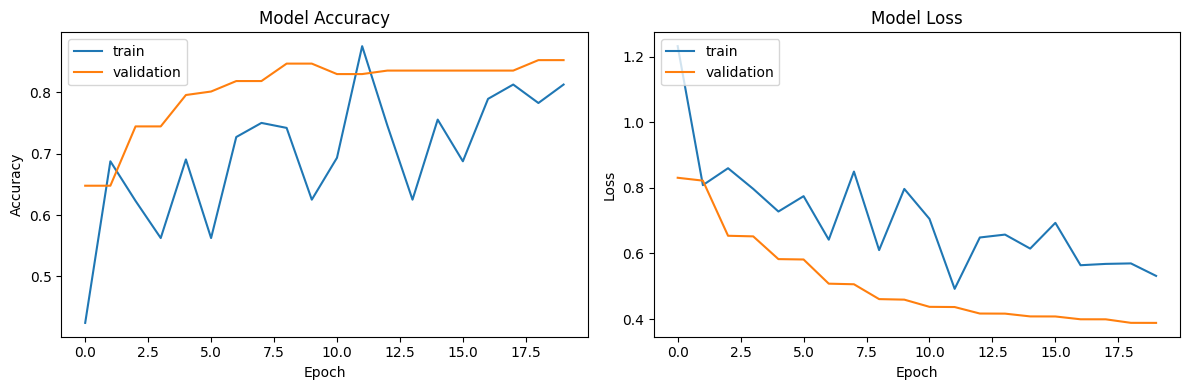


Using pre-trained YOLOv5 model for object detection...
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 58.2MB/s]

Found 190 images belonging to 3 classes.



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.8723 - loss: 0.3459
Test Loss: 0.3983
Test Accuracy: 0.8474
12/12 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step


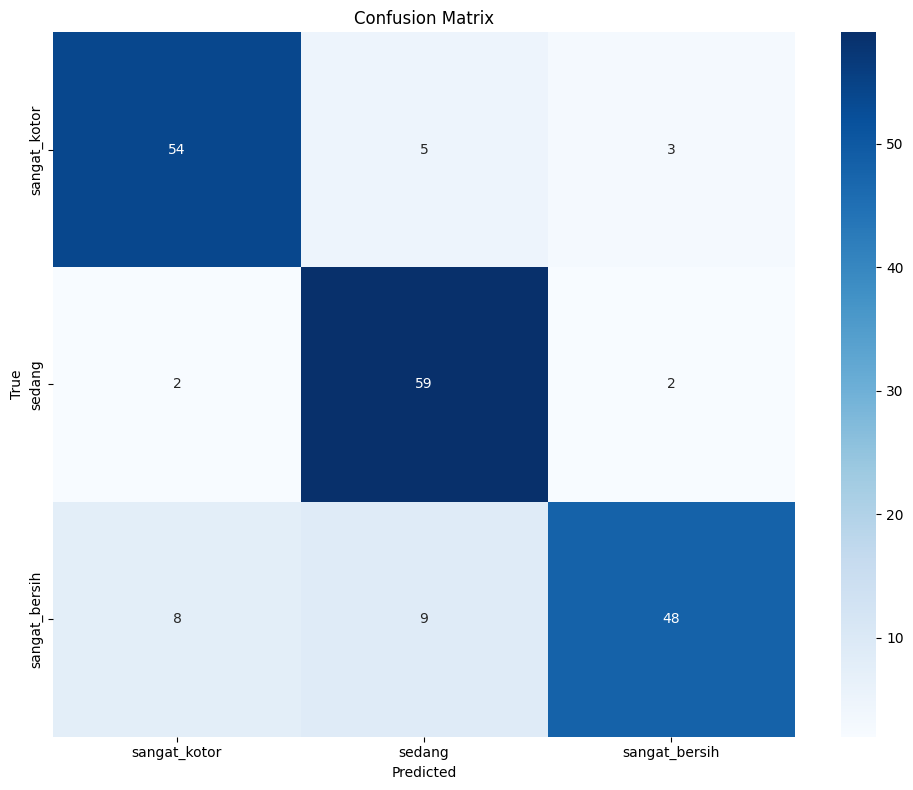


Classification Report:
               precision    recall  f1-score   support

 sangat_kotor       0.84      0.87      0.86        62
       sedang       0.81      0.94      0.87        63
sangat_bersih       0.91      0.74      0.81        65

     accuracy                           0.85       190
    macro avg       0.85      0.85      0.85       190
 weighted avg       0.85      0.85      0.85       190


Model sudah siap untuk memprediksi gambar baru!
Silahkan upload gambar lingkungan untuk diklasifikasi dan deteksi objek:


Saving IMG-20231130-WA0093.jpg to IMG-20231130-WA0093.jpg

Memprediksi gambar: IMG-20231130-WA0093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Hasil Klasifikasi Kebersihan:
  sangat_kotor: 84.76%
  sedang: 5.23%
  sangat_bersih: 10.00%

Objek Terdeteksi (0 total):


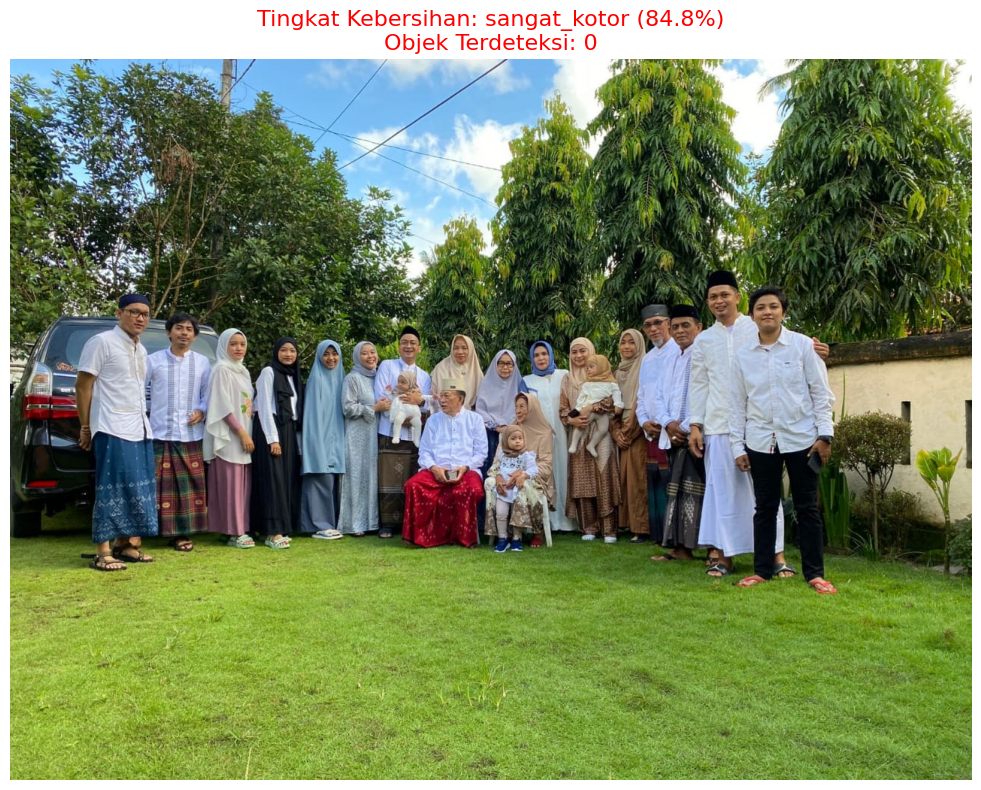


Analisis: Area terlihat sangat kotor, namun sedikit objek sampah terdeteksi. Mungkin ada masalah lain seperti tanah/air yang tercemar.

Proses selesai! Model hybrid berhasil dilatih dan dievaluasi.


In [ ]:
# MAIN PROCESS
# Persiapkan dataset
print("Persiapan dataset...")
train_data, val_data, data_dir = prepare_classification_dataset(dataset_dir, processed_data_dir)

# Train model hybrid
print("Model Hybrid: Klasifikasi Kebersihan + Object Detection (MobileNetV2)")
print("Training klasifikasi model...")

# Try-except untuk menangani kemungkinan error
try:
    # Train model
    classification_model, history = train_simplified_model()

    # Get detection model
    detection_model, detection_model_path = get_detection_model()

    # Evaluate model
    true_classes, predicted_classes, predictions = evaluate_model(classification_model, processed_data_dir)

    # Demo prediction
    print("\nModel sudah siap untuk memprediksi gambar baru!")
    predict_uploaded_image(classification_model, detection_model)

except Exception as e:
    print(f"\nERROR: {str(e)}")
    print("\nMencoba pendekatan alternatif...")

    # Pendekatan alternatif dengan mode CPU jika terjadi error
    with tf.device('/CPU:0'):
        print("Menggunakan CPU untuk training...")
        classification_model, history = train_simplified_model()

        # Get detection model
        detection_model, detection_model_path = get_detection_model()

        # Evaluate model
        true_classes, predicted_classes, predictions = evaluate_model(classification_model, processed_data_dir)

        # Demo prediction
        print("\nModel sudah siap untuk memprediksi gambar baru!")
        predict_uploaded_image(classification_model, detection_model)

print("\nProses selesai! Model hybrid berhasil dilatih dan dievaluasi.")